In [26]:
from __future__ import division
%pylab inline
import pandas as pd
import os
import json
from collections import defaultdict, Counter
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [27]:
def getCDF(data):
    xdata = np.sort(data)
    ydata = [i/len(xdata) for i in range(len(xdata))]
    return xdata, ydata

# 1. Number of sites per CDN

- Filter the domains served by a CDN
- Rank CDN providers by number of sites

In [28]:
df_cdn = pd.read_pickle("results/df_cdn.pkl")
df_ip_asn = pd.read_pickle("results/df_ip_asn.pkl")

In [29]:
print(len(df_ip_asn))
print(len(df_cdn))

df_valid_ip = df_ip_asn[df_ip_asn["ip"]!=False]
print(len(df_valid_ip))

500
500
480


### Domain to CDN
- Use a CDN names list from wikipedia and various websites
- Use a CDN domains list from github that maps certain urls to the CDN served
- Three methods are used to finally determine the CDN used by the site (code in find_cdn_methods.py) 
    1. Check if site itself is well known CDN by comparing it to CDN names and CDN domains
    2. Counting sources on site:
        - Download and parse the site homepage (using requests and BeautifulSoup) and find the url sources of static objects (images and scripts) as well as links on the webpage.
        - Count objects per source url, and find the url with maximum or substantial traffic.
        - Compare url to well known CDN domains. If it can't be resolved.
    3. Parsing organization information for whois:
        - Most websites have CDN provider in the whois information since their publically resolved IPs belong to the CDN
        - Compare 'Organization' tag in whois to popular CDN names.
- At times, method 2 gives us a certain cdn url with many static object (for ex: twitchcdn.net for twitch.tv) while the whois tells us which CDN the site uses (ex: Fastly for twitch.tv). This allows us to associate the cdn url or domain with the CDN name to populate our CDN_domain dictionary for future testing.

### Details of CDN finding algorithm
# <font color='red'> TODO </font>

- Minor improvements to algorithm:
    - HTTP header may contain CDN name in fields 'Server','x-cdn', or 'x-cache'
    - DNS CNAME might redirect us to CDN
    - "host site" returns IP addresses, but sometimes also returns server names containing CDN name
    - if returned server names dont have CDN name, we can still request the page being pointed to. For response code 500 the page may contain the name of CDN
    - Another simple way is to append "cdn." keyword to the site and try to see if this host exists (use host -a)

In [30]:
df_cdn[ df_cdn['cdn']=='daumcdn.net' ]

rank         site          cdn cdn.site    cdn.parse cdn.most_url  \
153   154     daum.net  daumcdn.net     None  daumcdn.net         None   
291   292  tistory.com  daumcdn.net     None  daumcdn.net         None   

    cdn.whois cdn.xcache cdn.cname  
153      None       None      None  
291      None       None      None

### Domains per CDNs
#### 480 sites of 500 were resolved to IPs, 20 sites were blocked by ISP
#### 302 sites were using CDNs, 198 were not. Of 302, 163 were resolved to CDNs by parsing objects on a page, while 139 sites did not show anything on parsing, but their organization name in whois records was a known CDN provider.
- For 198 sites, the organization name in the whois record of these sites was either the site name itself or a hosting service that is not commonly known as a CDN provider.
- This way we end up counting sites on Amazon's EC2 service, Akamai hosting, etc. as part of CDNs due to whois hosting records. This may not be true in all cases - a site may be hosting content on Amazon but not using Cloudfront.
- Confirmed CDNs includes any urls that host majority static content of a website and seem like a CDN url, for example cdn.comcast.com or twichcdn.com. We can add these domains to our domain: CDN mapping after resolving them to appropriate CDN names offline.

#### 163 sites were using 62 confirmed CDNs. Of these Google hosted 60, Cloudfront 17, Akamai 8, Alibaba 8, accounting for 93 websites amongst 4 CDNs. Of 139 websites detected on 24 CDNs through whois records, 34 used Cloudflare, 24 used Amazon, 22 were on Fastly, and 18 on Akamai. Apart from this 7 more websites were using Amazon Data Services and 8 were using Google Cloud but were not detected by parsing objects on their pages directly.

In [31]:
print("Number of sites estimated using CDNs (either parse method or whois method) = ",
      len( df_cdn[~df_cdn['cdn'].isnull() | ~df_cdn['cdn.whois'].isnull()] ) )
print("Number of sites estimated using CDNs (parse method) = ",
      len( df_cdn[~df_cdn['cdn'].isnull()] ) )
print("Number of sites estimated using CDNs (whois method only) = ",
      len( df_cdn[df_cdn['cdn'].isnull() & ~df_cdn['cdn.whois'].isnull()] ) )

print("Number of sites estimated not using CDNs (neither parse method nor whois method) = ",
      len( df_cdn[df_cdn['cdn'].isnull() & df_cdn['cdn.whois'].isnull()] ) )
print("Number of sites estimated not using CDNs (parse method only) = ",
      len( df_cdn[df_cdn['cdn'].isnull()] ) )

Number of sites estimated using CDNs (either parse method or whois method) =  302
Number of sites estimated using CDNs (parse method) =  163
Number of sites estimated using CDNs (whois method only) =  139
Number of sites estimated not using CDNs (neither parse method nor whois method) =  198
Number of sites estimated not using CDNs (parse method only) =  337


In [32]:
df_cdn_parse = df_cdn[~df_cdn['cdn'].isnull()]
df_cdn_whois_only = df_cdn[ df_cdn['cdn'].isnull() & ~df_cdn['cdn.whois'].isnull() ]
df_not_cdn = df_cdn[df_cdn['cdn'].isnull() & df_cdn['cdn.whois'].isnull()]

print(len(df_cdn_parse), len(df_cdn_whois_only), len(df_not_cdn))

163 139 198


In [33]:
num_sites_per_cdn = df_cdn_parse.groupby('cdn')['rank'].count().sort_values(ascending=False)
print("Total number of individual CDNs (detected through parsing) = ", len(num_sites_per_cdn))
print("Number of sites confirmed using CDNs = ", (sum(num_sites_per_cdn)) )

num_sites_per_cdn_whois_only = df_cdn_whois_only.groupby('cdn.whois')['rank'].count().sort_values(ascending=False)
print("Total number of individual CDNs (detected through whois but not parsing) = ",
      len(num_sites_per_cdn_whois_only))
print("Number of sites estimated using CDNs based on whois records only = ", (sum(num_sites_per_cdn_whois_only)) )

Total number of individual CDNs (detected through parsing) =  62
Number of sites confirmed using CDNs =  163
Total number of individual CDNs (detected through whois but not parsing) =  24
Number of sites estimated using CDNs based on whois records only =  139


## Group sites by Major CDN, known CDN, unknown CDN URL, and No CDN

#### Major CDNs account for 210 of 302 CDN using sites.
- Adding confirmed CDNs through page parsing and those from whois records together (i.e., considering sites hosted on Amazon as well as those confirmed using Cloudfront together): Amazon hosts 48 sites, Google hosts 68 sites, Cloudflare hosts 34, Fastly 24, Akamai 26, and Alibaba 12.

#### 42 sites on known CDNs (from our list of CDN names)
- For other sites, some popular CDNs, such as 'Open-Connect', only cater to a single popular domain (netflix.com). Others (like Incapsula) cater to multiple sites (prothomalo.com, kooora.com) that are lower on the Alexa ranking. CDNs like Facebook and Microsoft specifically cater to limited sites with higher ranking on Alexa.

#### 50 sites on unknown CDNs (url contains the string "cdn" but we haven't resolved it to a specific site)
- Certain domains like cdn.comcast.net and twitchcdn.com host majority traffic for websites and seem like CDNs, but their domains/urls are not in our offline list.

#### Of 198 sites that are not using CDNs, 83 sites host majority traffic on a certain url that is probably not a CDN.
- This includes urls such as "assets.tumblr.com", "cfl.dropboxstatic.com", etc. We don't consider these domains as CDNs and instead assume they are static servers/hosts. For these websites, we could not find a famous CDN name in their whois information either.

In [48]:
major_cdn_names = {"Amazon":0, "Google":0, "Cloudflare":0, "Fastly":0, "Akamai":0, "Alibaba":0}

for m_cdn_name in major_cdn_names.keys():
    for cdn, num_sites in num_sites_per_cdn_whois_only.items():
        if m_cdn_name in cdn:
            major_cdn_names[m_cdn_name]+=num_sites
    for cdn, num_sites in num_sites_per_cdn.items():
        if m_cdn_name in cdn:
            major_cdn_names[m_cdn_name]+=num_sites

print(major_cdn_names)

{'Amazon': 48, 'Google': 68, 'Cloudflare': 34, 'Fastly': 24, 'Akamai': 26, 'Alibaba': 10}


In [59]:
def group_cdn_name(cdn_name):
    major_cdn_names = ["Amazon", "Google", "Cloudflare", "Fastly", "Akamai", "Alibaba", "Facebook", "Microsoft", "Yahoo"]
    if cdn_name is not None:
        for m in major_cdn_names:
            if m in cdn_name:
                return m
            elif "Taobao" in cdn_name:
                return "Alibaba"
        if cdn_name.lower()==cdn_name:
            return "UNKNOWN CDN URL"
        else:
            return "KNOWN CDN"
    else:
        return "NO CDN"
        

df_cdn["cdn_all"] = df_cdn.apply(lambda x: x["cdn"] if x["cdn"]!=None else x["cdn.whois"], axis=1)
#df_cdn
df_cdn["cdn_grouped"] = df_cdn["cdn_all"].apply(group_cdn_name)

In [60]:
df_cdn.groupby("cdn_grouped")["rank"].count()

cdn_grouped
Akamai              26
Alibaba             12
Amazon              48
Cloudflare          34
Facebook             5
Fastly              24
Google              68
KNOWN CDN           24
Microsoft            7
NO CDN             198
UNKNOWN CDN URL     50
Yahoo                4
Name: rank, dtype: int64

In [61]:
df_no_cdn = df_cdn[df_cdn["cdn_grouped"]=="NO CDN"]

print("Number of sites confirmed NOT CDN (using parse and whois) =", len(df_no_cdn))
print("Number of sites that are NOT CDN but most objects are still hosted on a single url =",
      len(df_no_cdn[ ~df_no_cdn["cdn.most_url"].isnull() ]))

Number of sites confirmed NOT CDN (using parse and whois) = 198
Number of sites that are NOT CDN but most objects are still hosted on a single url = 83


In [62]:
print("Some popular CDNs catering to a few websites, and deciding their CDNs based on page parsing and whois data")
df_cdn[ df_cdn['cdn_all'].isin( ['Yahoo', 'Facebook', 'Edgecast', 'Incapsula'] ) ]

Some popular CDNs catering to a few websites, and deciding their CDNs based on page parsing and whois data


rank            site       cdn  cdn.site cdn.parse  \
2       3    facebook.com  Facebook  Facebook  Facebook   
6       7       yahoo.com     Yahoo     Yahoo     Yahoo   
18     19   instagram.com  Facebook  Facebook      None   
28     29     yahoo.co.jp     Yahoo      None     Yahoo   
45     46    whatsapp.com  Facebook      None  Facebook   
79     80       fbcdn.net  Facebook  Facebook  Facebook   
230   231   messenger.com  Facebook      None  Facebook   
403   404      flickr.com     Yahoo      None     Yahoo   
445   446  prothomalo.com      None      None      None   
481   482      kooora.com      None      None      None   
494   495        oath.com      None      None      None   

                   cdn.most_url                 cdn.whois cdn.xcache  \
2                          None                  Facebook       None   
6                          None                     Yahoo       None   
18                         None  Amazon Technologies Inc.       None   
28                         None                     Yahoo       None   
45                         None                 SoftLayer       None   
79                         None                  Facebook       None   
230                        None                  Facebook       None   
403                        None                     Yahoo       None   
445  paloimages.prothom-alo.com                 Incapsula       None   
481                        None                 Incapsula       None   
494        s.blogsmithmedia.com                     Yahoo       None   

    cdn.cname    cdn_all cdn_grouped  
2        None   Facebook    Facebook  
6        None      Yahoo       Yahoo  
18       None   Facebook    Facebook  
28       None      Yahoo       Yahoo  
45       None   Facebook    Facebook  
79       None   Facebook    Facebook  
230      None   Facebook    Facebook  
403      None      Yahoo       Yahoo  
445      None  Incapsula   KNOWN CDN  
481      None  Incapsula   KNOWN CDN  
494      None      Yahoo       Yahoo

#### Save grouped data

In [63]:
df_cdn_grouped = df_cdn[["rank", "site", "cdn", "cdn.most_url", "cdn.whois", "cdn_all", "cdn_grouped"]]
df_cdn_grouped.to_pickle("results/df_cdn_grouped.pkl")

In [65]:
df_cdn_grouped[ df_cdn_grouped["site"]=="youku.com" ]


rank       site   cdn      cdn.most_url cdn.whois cdn_all cdn_grouped
353   354  youku.com  None  static.youku.com    Taobao  Taobao     Alibaba

# 2. ASN vs CDN
- 224 of 500 sites have direct mapping between AS name and CDN name
- 20 websites have no ASN due to IP block
- Of 256 websites, 
    - 180 sites were using no CDNs
    - and 48 were UNKNOWN CDN URL
    - 28 websites were detected on a certain known CDN that did not match the AS name (Akamai 7, Alibaba 1, Amazon 3, Cloudflare 1, KNOWN CDN 16).

In [84]:
#df_ip_asn = pd.read_pickle('results/df_ip_asn_grouped.pkl')
#df_ip_asn_cdn = df_cdn.merge(df_ip_asn, on=["rank", "site"])

In [160]:
df_asn_cdn = df_ip_asn_cdn[["rank", "site", "cdn.whois", "cdn_all", "cdn_grouped", "ip", "asn", "asname"]].copy()

In [161]:
major_as_names = ["Amazon", "Google", "Microsoft", "Cloudflare", "Fastly", "Facebook",
                  "ChinaNet", "Yahoo", "Akamai", "Alibaba"]

def group_as_name(as_name):
    if as_name is not False:
        for m in major_as_names:
            if m.lower() in as_name.lower():
                return m
        return as_name.split(" ")[0].strip(",").strip()
    else:
        return ""
    
df_asn_cdn['as_grouped'] = df_asn_cdn["asname"].apply(group_as_name)

In [162]:
def find_equal_asname_cdn(vals):
    #print(vals)
    #if not vals["cdn_grouped"] in ["NO CDN", "UNKNOWN CDN URL"]:
    if vals["asn"]!=False:
        if vals["as_grouped"] and vals["cdn_all"]:
            if (vals["as_grouped"].lower() in vals["cdn_all"].lower() or
                vals["as_grouped"].lower() in vals["cdn_grouped"].lower()):
                return True
    return False

df_asn_cdn["cdn==asn"] = df_asn_cdn.apply(lambda val: find_equal_asname_cdn(val), axis=1)            

In [163]:
print(len(df_asn_cdn))
print(len(df_asn_cdn[df_asn_cdn["cdn==asn"]==True]))
print(len(df_asn_cdn[(df_asn_cdn["cdn==asn"]==True) & (df_asn_cdn["ip"]==False)]))
print(len(df_asn_cdn[(df_asn_cdn["cdn==asn"]==False) & (df_asn_cdn["ip"]==False)]))
print(len(df_asn_cdn[df_asn_cdn["cdn==asn"]==False]))

500
224
0
20
276


In [164]:
df_asn_cdn.groupby("cdn_grouped")['site'].count()

cdn_grouped
Akamai              26
Alibaba             10
Amazon              48
Cloudflare          34
Fastly              24
Google              68
KNOWN CDN           42
NO CDN             198
UNKNOWN CDN URL     50
Name: site, dtype: int64

In [165]:
df_asn_cdn[(df_asn_cdn['ip']==False)]

rank                   site cdn.whois            cdn_all cdn_grouped  \
34     35            pornhub.com      None               None      NO CDN   
51     52                  ok.ru      None               None      NO CDN   
53     54         livejasmin.com      None               None      NO CDN   
63     64            xvideos.com      None               None      NO CDN   
65     66  googleusercontent.com      None             Google      Google   
71     72           xhamster.com      None               None      NO CDN   
102   103             exosrv.com      None               None      NO CDN   
112   113               xnxx.com      None               None      NO CDN   
181   182         chaturbate.com      None               None      NO CDN   
227   228                 yts.am      None               None      NO CDN   
238   239            youporn.com      None               None      NO CDN   
276   277               1337x.to      None               None      NO CDN   
284   285         cloudfront.net      None  Amazon CloudFront      Amazon   
311   312            redtube.com      None               None      NO CDN   
327   328          rutracker.org      None               None      NO CDN   
333   334           banvenez.com      None               None      NO CDN   
336   337        bp.blogspot.com      None               None      NO CDN   
387   388           exdynsrv.com      None               None      NO CDN   
388   389                sex.com      None               None      NO CDN   
484   485            wixsite.com      None               None      NO CDN   

        ip    asn asname as_grouped  cdn==asn  
34   False  False  False                False  
51   False  False  False                False  
53   False  False  False                False  
63   False  False  False                False  
65   False  False  False                False  
71   False  False  False                False  
102  False  False  False                False  
112  False  False  False                False  
181  False  False  False                False  
227  False  False  False                False  
238  False  False  False                False  
276  False  False  False                False  
284  False  False  False                False  
311  False  False  False                False  
327  False  False  False                False  
333  False  False  False                False  
336  False  False  False                False  
387  False  False  False                False  
388  False  False  False                False  
484  False  False  False                False

## 28 CDN != ASN
- 3/28 on taobao and alibaba
- 7/28 used Akamai but ASNs did not correspond to Akamai. Includes msn.com on Microsoft ASN that is known to use Akamai CDN architecture, as well as salesforce.com and force.com that are also known to use Akamai and were detected as such. liputan6.com	using Akamai to host most of its resources but on Amazon's ASN.
- 3/28 sites using Amazon Cloudfront were amazon.cn (on China Unicom), trello.com (on Akamai), and bitly.com (on Bitly-AS). Apart from this instagram.com and netflix.com were detected on Amazon's AS though they are known to use Facebook CDN and Open-Connect CDN respectively. This might be because we are requesting their home page from India. 
- 13/28 sites hosted on different ASNs were using various popular CDNs including whatsapp.com, which is registered to SoftLayer's AP but uses Facebook CDN.

In [166]:
df_interesting = df_asn_cdn[(df_asn_cdn["cdn==asn"]==False) & ~(df_asn_cdn["ip"]==False)]

In [167]:
df_interesting.groupby("cdn_grouped")['site'].count()

cdn_grouped
Akamai               7
Alibaba              1
Amazon               3
Cloudflare           1
KNOWN CDN           16
NO CDN             180
UNKNOWN CDN URL     48
Name: site, dtype: int64

In [169]:
df_interesting[~df_interesting["cdn_grouped"].isin(["NO CDN",
                                                     "UNKNOWN CDN URL"])].sort_values(by="cdn_grouped").set_index('rank')

site                 cdn.whois  \
rank                                                       
365                   asos.com                    Akamai   
279               liputan6.com      Amazon Data Services   
452              investing.com                      None   
51                   naver.com                      None   
56                     msn.com                 Microsoft   
105             salesforce.com                      None   
117                  force.com                      None   
23             login.tmall.com                      None   
245                  amazon.cn                      None   
215                 trello.com                    Akamai   
464                  bitly.com                      None   
336              sindonews.com                Cloudflare   
406        files.wordpress.com                      None   
366                   hola.com                      Hola   
19               instagram.com  Amazon Technologies Inc.   
364                 zol.com.cn            ChinaNetCenter   
354                  youku.com                    Taobao   
352               outbrain.com                  Internap   
189              people.com.cn                ChinaCache   
208                  twimg.com                      None   
308                  orange.fr                    Orange   
307                  ifeng.com            ChinaNetCenter   
287   onlinevideoconverter.com                      None   
27                 netflix.com      Amazon Data Services   
46                whatsapp.com                 SoftLayer   
63               wordpress.com                      None   
310                   zoho.com                   Level 3   
9                   taobao.com                    Taobao   

                     cdn_all cdn_grouped               ip     asn  \
rank                                                                
365                   Akamai      Akamai  118.215.155.188    9498   
279                   Akamai      Akamai      54.169.7.71   16509   
452                   Akamai      Akamai    185.94.84.100   56647   
51                    Akamai      Akamai    210.89.164.90   23576   
56                    Akamai      Akamai      13.82.28.61    8075   
105                   Akamai      Akamai     96.43.149.26   14340   
117                   Akamai      Akamai    204.74.99.100   12008   
23                   Alibaba     Alibaba     47.246.1.233   24429   
245        Amazon CloudFront      Amazon    54.222.60.218    4808   
215        Amazon CloudFront      Amazon     23.41.75.178   16625   
464        Amazon CloudFront      Amazon    67.199.248.14  395224   
336               Cloudflare  Cloudflare   182.253.240.29   17451   
406                WordPress   KNOWN CDN       192.0.72.3    2635   
366                     Hola   KNOWN CDN     62.22.171.50     702   
19                  Facebook   KNOWN CDN    52.72.165.230   14618   
364           ChinaNetCenter   KNOWN CDN    123.103.57.17    4808   
354                   Taobao   KNOWN CDN    106.11.186.25   37963   
352                 Internap   KNOWN CDN     50.31.185.52   23352   
189               ChinaCache   KNOWN CDN   118.143.207.39   55355   
208                  Twitter   KNOWN CDN   210.163.219.24    4713   
308                   Orange   KNOWN CDN   193.252.133.34    8891   
307           ChinaNetCenter   KNOWN CDN   123.103.122.24    4808   
287                StackPath   KNOWN CDN   94.228.214.149   47869   
27    Open-Connect (Netflix)   KNOWN CDN     34.249.62.22   16509   
46                  Facebook   KNOWN CDN  192.155.212.202   36351   
63                 WordPress   KNOWN CDN      192.0.78.17    2635   
310                  Level 3   KNOWN CDN      8.39.54.155    2639   
9                     Taobao   KNOWN CDN   140.205.94.189   37963   

                                                 asname     as_grouped  \
rank                                                                     
365   

In [193]:
df_url_cdns = df_interesting[df_interesting["cdn_grouped"]=="UNKNOWN CDN URL"][['site', 'cdn_all', "cdn.whois",
                                                                  'asn', 'as_grouped']].sort_values(by='as_grouped')
print(len(df_url_cdns))

48


In [194]:
print(len( df_url_cdns[ ~df_url_cdns['cdn.whois'].isnull() ] ))

df_url_cdns[ ~df_url_cdns['cdn.whois'].isnull() ]

27


site                        cdn_all  \
183       gearbest.com                     gbtcdn.com   
496           souq.com                    souqcdn.com   
83            espn.com                    espncdn.com   
88           quora.com                   quoracdn.net   
431          chegg.com                   cheggcdn.com   
124     soundcloud.com                     sndcdn.com   
447          prezi.com                   prezicdn.net   
441        shopify.com                cdn.shopify.com   
171     wetransfer.com        prod-cdn.wetransfer.net   
164           vice.com  vice-web-statics-cdn.vice.com   
349        xfinity.com                cdn.comcast.com   
469           egy.best                   cdn.egy.best   
396     ensonhaber.com            icdn.ensonhaber.com   
332      gamepedia.com                   cursecdn.com   
158           txxx.com                    pix-cdn.org   
323    tripadvisor.com                      tacdn.com   
476       theverge.com                cdn.vox-cdn.com   
40           twitch.tv                  twitchcdn.net   
266      speedtest.net                      cdnst.net   
254           yelp.com                    yelpcdn.com   
118  stackexchange.com                cdn.sstatic.net   
139          vimeo.com                   vimeocdn.com   
204       softonic.com                     sftcdn.net   
109        spotify.com                        scdn.co   
372     slickdeals.net              slickdealscdn.com   
152     slideshare.net              slidesharecdn.com   
350            aol.com                     aolcdn.com   

                    cdn.whois    asn    as_grouped  
183                    Akamai  16625        Akamai  
496      Amazon Data Services  16509        Amazon  
83   Amazon Technologies Inc.  16509        Amazon  
88   Amazon Technologies Inc.  14618        Amazon  
431  Amazon Technologies Inc.  16509        Amazon  
124  Amazon Technologies Inc.  16509        Amazon  
447  Amazon Technologies Inc.  14618        Amazon  
441  Amazon Technologies Inc.  14618        Amazon  
171  Amazon Technologies Inc.  16509        Amazon  
164  Amazon Technologies Inc.  14618        Amazon  
349                   Comcast   7922  COMCAST-7922  
469                Cloudflare  13335    Cloudflare  
396                Cloudflare  13335    Cloudflare  
332                Cloudflare  13335    Cloudflare  
158                Cloudflare  13335    Cloudflare  
323                  EdgeCast  15133      EDGECAST  
476                    Fastly  54113        Fastly  
40                     Fastly  54113        Fastly  
266                    Fastly  54113        Fastly  
254                    Fastly  54113        Fastly  
118                    Fastly  54113        Fastly  
139                    Fastly  54113        Fastly  
204                    Google  15169        Google  
109                    Google  15169        Google  
372             Instart Logic  33047       INSTART  
152              LinkedIn CDN  14413      LINKEDIN  
350                     Yahoo  34010         Yahoo

In [195]:
df_url_cdns[ df_url_cdns['cdn.whois'].isnull() ]

site              cdn_all cdn.whois     asn  \
461           marca.com             uecdn.es      None    9052   
337             box.com     cdn03.boxcdn.net      None   33011   
199       patria.org.ve    cdn.patria.org.ve      None    8048   
315              yy.com        bs2cdn.yy.com      None   58543   
146     dailymotion.com            dmcdn.net      None   41690   
153            daum.net          daumcdn.net      None    9764   
475        usatoday.com      gannett-cdn.com      None   21735   
147        nicovideo.jp          cdn.nimg.jp      None    2510   
498         merdeka.com       cdns.klimg.com      None   58497   
291         tistory.com          daumcdn.net      None   38099   
393        elsevier.com      cdn.elsevier.io      None    3356   
251         reverso.net      cdn.reverso.net      None   25593   
470    surveymonkey.com     cdn.smassets.net      None   18915   
478            rarbg.to            dyncdn.me      None  200097   
434             onet.pl              ocdn.eu      None   12990   
400           douyu.com          douyucdn.cn      None   54994   
450         okezone.com      cdn.okezone.com      None   23946   
202         jianshu.com      cdn2.jianshu.io      None  135377   
273          weebly.com  cdn2.editmysite.com      None   27647   
404        idntimes.com     cdn.idntimes.com      None   58381   
453  huffingtonpost.com           aolcdn.com      None   34010   

                     as_grouped  
461                              
337                      BOXNET  
199                       CANTV  
315  CHINATELECOM-GUANGDONG-IDC  
146                 DAILYMOTION  
153                    DAUM-NET  
475              GANNET-3-21735  
147                     INFOWEB  
498               INTEGRA-AS-ID  
291                 KAKAO-AS-KR  
393                      LEVEL3  
251                LINKBYNET-AS  
470                MONKEY-US-01  
478                     NETSAAP  
434                 ONET-PL-AS1  
400             QUANTILNETWORKS  
450                TOPNET-AS-ID  
202                  UHGL-AS-AP  
273                      WEEBLY  
404               WOWRACK-AS-ID  
453                       Yahoo

In [207]:
df_check_for_cdns = df_interesting[ (df_interesting["cdn_grouped"]=="NO CDN")].copy()

df_check_for_cdns['asname.lower'] = df_check_for_cdns['asname'].apply(lambda x: x.lower())

In [228]:
from utils.CDNdomains import cdn_names, cdn_domains
cdn_names_all = list( set( cdn_names + list( cdn_domains.values() ) ) )

def check_for_cdn_name(asname):
    for cdn in cdn_names_all:
        if cdn.lower() in asname:
            print(cdn, asname)
            return cdn
    return None

In [229]:
df_check_for_cdns['cdn_checked'] = df_check_for_cdns['asname.lower'].apply(check_for_cdn_name)

China Telecom chinanet-idc-bj-ap idc, china telecommunications corporation, cn
Alibaba cnnic-alibaba-cn-net-ap hangzhou alibaba advertising co.,ltd., cn
NTT ntt-communications-2914 - ntt america, inc., us
Alibaba cnnic-alibaba-cn-net-ap hangzhou alibaba advertising co.,ltd., cn
Telin telin-net-sg telekomunikasi indonesia international, pte.ltd, sg
Yahoo yahoo-3 - yahoo!, us
Alibaba cnnic-alibaba-cn-net-ap hangzhou alibaba advertising co.,ltd., cn
Alibaba cnnic-alibaba-cn-net-ap hangzhou alibaba advertising co.,ltd., cn
Alibaba cnnic-alibaba-cn-net-ap hangzhou alibaba advertising co.,ltd., cn
China Telecom chinanet-sh-ap china telecom (group), cn
Alibaba cnnic-alibaba-cn-net-ap hangzhou alibaba advertising co.,ltd., cn
Alibaba cnnic-alibaba-cn-net-ap hangzhou alibaba advertising co.,ltd., cn
China Telecom chinanet-idc-bj-ap idc, china telecommunications corporation, cn
China Telecom chinanet-sh-ap china telecom (group), cn
Amazon.com, Inc. amazon-02 - amazon.com, inc., us
Amazon.com, In

In [232]:
df_maybe_cdns = df_check_for_cdns[~df_check_for_cdns['cdn_checked'].isnull()]

In [234]:
print(len(df_maybe_cdns))

22


In [235]:
df_maybe_cdns

rank              site cdn.whois cdn_all cdn_grouped               ip  \
21     22            360.cn      None    None      NO CDN    36.110.213.49   
32     33          csdn.net      None    None      NO CDN    47.95.164.112   
38     39   pages.tmall.com      None    None      NO CDN    202.47.28.119   
41     42        alipay.com      None    None      NO CDN     110.75.129.5   
60     61    tribunnews.com      None    None      NO CDN   180.240.134.85   
70     71        tumblr.com      None    None      NO CDN       66.6.33.31   
86     87  detail.tmall.com      None    None      NO CDN    121.42.17.238   
117   118       cnblogs.com      None    None      NO CDN    42.121.252.58   
127   128      babytree.com      None    None      NO CDN   59.110.149.245   
132   133         iqiyi.com      None    None      NO CDN  101.227.188.174   
137   138          panda.tv      None    None      NO CDN    182.92.20.106   
157   158         zhanqi.tv      None    None      NO CDN   182.92.104.151   
182   183    caijing.com.cn      None    None      NO CDN   124.243.192.30   
220   221       eastday.com      None    None      NO CDN    222.73.244.10   
228   229    duckduckgo.com      None    None      NO CDN   54.254.135.186   
330   331      academia.edu      None    None      NO CDN   46.137.210.247   
339   340         pixiv.net      None    None      NO CDN  210.140.131.224   
352   353        kakaku.com      None    None      NO CDN  210.129.151.129   
419   420         pikabu.ru      None    None      NO CDN   91.228.155.121   
430   431         baike.com      None    None      NO CDN  124.243.228.136   
460   461         goo.ne.jp      None    None      NO CDN   153.254.147.65   
482   483      dcinside.com      None    None      NO CDN    221.143.22.47   

       asn                                             asname  \
21   23724  CHINANET-IDC-BJ-AP IDC, China Telecommunicatio...   
32   37963  CNNIC-ALIBABA-CN-NET-AP Hangzhou Alibaba Adver...   
38    2914    NTT-COMMUNICATIONS-2914 - NTT America, Inc., US   
41   37963  CNNIC-ALIBABA-CN-NET-AP Hangzhou Alibaba Adver...   
60   56308  TELIN-NET-SG TELEKOMUNIKASI INDONESIA INTERNAT...   
70   26101                               YAHOO-3 - Yahoo!, US   
86   37963  CNNIC-ALIBABA-CN-NET-AP Hangzhou Alibaba Adver...   
117  37963  CNNIC-ALIBABA-CN-NET-AP Hangzhou Alibaba Adver...   
127  37963  CNNIC-ALIBABA-CN-NET-AP Hangzhou Alibaba Adver...   
132   4812           CHINANET-SH-AP China Telecom (Group), CN   
137  37963  CNNIC-ALIBABA-CN-NET-AP Hangzhou Alibaba Adver...   
157  37963  CNNIC-ALIBABA-CN-NET-AP Hangzhou Alibaba Adver...   
182  23724  CHINANET-IDC-BJ-AP IDC, China Telecommunicatio...   
220   4812           CHINANET-SH-AP China Telecom (Group), CN   
228  16509                   AMAZON-02 - Amazon.com, Inc., US   
330  16509                   AMAZON-02 - Amazon.com, Inc., US   
339   4694                    IDC Yahoo Japan Corporation, JP   
352   4694                    IDC Yahoo Japan Corporation, JP   
419  44066                DE-FIRSTCOLO www.first-colo.net, DE   
430  23724  CHINANET-IDC-BJ-AP IDC, China Telecommunicatio...   
460   2914    NTT-COMMUNICATIONS-2914 - NTT America, Inc., US   
482   9318                     SKB-AS SK Broadband Co Ltd, KR   

                  as_grouped  cdn==asn  \
21                  ChinaNet     False   
32                   Alibaba     False   
38   NTT-COMMUNICATIONS-2914     False   
41                   Alibaba     False   
60              TELIN-NET-SG     False   
70                     Yahoo     False   
86                   Alibaba     False   
117                  Alibaba     False   
127                  Alibaba     False   
132                 ChinaNet     False   
137                  Alibaba     False   
157                  Alibaba     False   
182                 ChinaNet     False   
220                 ChinaNet     False   
228                   Amazon     False   
330                   Amazon     False   


# Notes on ASN-CDN mapping
- Having the same ASN doesn't essentially mean you are using the same CDN as other sites on that ASN. Ex: Using Amazon AWS with static hosting on S3 servers. Although there is a higher chance that site will use CDN provided by their ASN host since architecture should be better.

- AS38895 belongs to Amazon. But whois duckduckgo.com returned wrong format with no clear Organization name. It should be updated to "Amazon AWS" after fixing whois page parsing.
    - duckduckgo's home page did not have any particular resources hosted on url's associated with Amazon. Neither does duckduckgo state that it is using a CDN (possibly due to privacy concerns). Thus sites on Amazon AWS should be analyzed separately as some may be part of CDNs while others are not.
    - similarly most objects on liputan6.com were infact hosted on akamaized.net (Akamai) instead of Cloudfront despite being on Amazon AWS.
    - AS numbers may be a good indicator of CDNs, but priority should be given to page parsing for known CDN names or cdn based domains (instead of whois information and AS names). This is because certain AS might be providing enterprise and access/transit services apart from content hosting and delivery.

- Similarly Akamai has also been known to provide both CDN and transit services. Thus just ASN is not a reliable indicator of CDN usage.

- Taobao belongs to Alibaba Inc. and all sites are on the same ASN, but some do not seem to be using CDN service based on static objects being hosted locally.

- amazon.cn is on AS4808 China Unicom, but is definitely using Amazon AWS. ifeng.com is also on the same ASN but using ChinaNetCenter for content delivery based on whois records

In [ ]:
gp3 = result.groupby(['asn', 'cdn_grouped'])

In [ ]:
cdn_asn_detect = gp3['site'].count().sort_values(ascending=False).reset_index()

In [ ]:
# Check if multiple CDNs were detected for the same ASN -> should not happen

gp4 = cdn_asn_detect.groupby('ASN')
df3 = gp4.aggregate(lambda x: list(x)).reset_index().set_index('ASN')
df3['num_cdn']=gp4['site'].count()
df3['num_sites']=gp4['site'].sum()

df3[ df3['num_cdn']>1 ]

In [ ]:
asns = df3[ df3['num_cdn']>1 ].index

result[result['ASN'].isin([38895])]

In [ ]:
result[result['ASN'].isin([37963])]

In [ ]:
result[result['ASN'].isin([4808])]

In [ ]:

result[result['ASN'].isin([4134])]

# 2. Site timings per CDN

## 2a. Extracting timings using curl

- Use curl to query top 500 websites 100 times. Extract individual timings for received packets (see https://ec.haxx.se/usingcurl-verbose.html ). Calculate required timing data.
    - t_dns = time for DNS resolution (no redirects) = time_namelookup - time_redirect  
    - t_tcp = time for TCP connection (SYN/SYNACK) = time_connect - time_namelookup  
    - t_ssl = time for SSL handshake (only if https) = time_appconnect - time_connect  
    - t_fbyte = time_starttransfer
    - t_wait = time between issuing GET request and first byte received (server calculation time) = time_starttransfer - time_pretransfer  
    - t_rx = time to receive data from first to last byte = time_total - time_starttransfer 
- Sites such as google, reddit, and others on CDNs ban the IP very soon since they are able to detect multiple queries from the same address. Use parallization and ensure that there is a random time interval (1-5 mins) between each query to the same website. Also, change the user-agent string in the request header if needed.

#### Blocked Sites
- 49 of 500 websites were blocked (completely unreachable) when using curl. . As a first step we will remove them from timing analysis.
- Requests to these sites timed out (more than 10s) consistently and we received no response except status codes 0 for all of them.
    - Of these, 18 websites could not be resolved to a host IP address. These include porn and adware sites blocked by the ISP. However, curl is able to successfully reach 2 websites {'googleusercontent.com', 'wixsite.com'} that originally couldn't be resolved to a host IP. This may be because of redirects when using curl.
    - Some of these sites are completely blocked (such as microsoftonline.com, cloudfront.net, twimg.com, redd.it) and were unreachable even from browsers. These servers should be meant for specific authenticated services or traffic coming from specific IP addresses. They might have their port 80 and 443 blocked or IPs other than internal firewalled.
    - Many chinese websites (\*.tmall.com, xinhuanet.com, gmw.cn, etc.) did not respond to curl requests but can be opened manually on browsers. These sites probably detect scripting (maybe through user agent strings) and time out when using curl. They were reachable manually although they took a noticably long time to load.
    - Certain sites (bodelen.com, swiftviz.net, resentaticexhaus.info, etc.) are well known adware and redirect virus websites. These are blocked by the ISP and can't be accessed on browsers. When trying to get the host IP, they redirect to the address for well known websites such as google and whois information ends up showing information on google.com's homepage erroniously. These websites should be removed from CDN and BGP analysis.
- 446 of 500 sites responded with a valid status code other than 0 for more than 90 requests each.
- Only 5 sites ['rednet.cn', 'ci123.com', 'bestbuy.com', 'washingtonpost.com', 'youdao.com'] had a response rate between 40 - 90 %.

In [1034]:
df_timing = pd.read_pickle("output/df_timing.pkl")
df_timing['status_ok'] = df_timing['response_code']==200
df_timing['status_fail'] = df_timing['response_code']==0

In [1065]:
df_responses = df_timing[ (df_timing['status_fail']==False) ]
print("Number of sites with at least one non-zero status response:", len(df_responses['rank'].unique()))

df_unreachable = df_timing[ ~df_timing['rank'].isin(df_responses['rank'].unique()) ]

print("Number of absolutely unreachable or blocked requests:", len(df_unreachable))
print("Unreachable sites:", len(df_unreachable['rank'].unique()))

#df_unreachable.merge(df_asn_cdn, on='rank')
#df_asn_cdn[ df_asn_cdn['rank'].isin(df_unreachable['rank'].unique()) ]

bad_sites2 = list(df_all[ df_all['rank'].isin(df_unreachable['rank'].unique()) ]['site'])
print("List of failed sites = ", bad_sites2)

Number of sites with at least one non-zero status response: 451
Number of absolutely unreachable or blocked requests: 4900
Unreachable sites: 49
List of failed sites =  ['login.tmall.com', 'microsoftonline.com', 'pornhub.com', 'pages.tmall.com', 'ok.ru', 'livejasmin.com', 'xvideos.com', 'xhamster.com', 'detail.tmall.com', 'xinhuanet.com', 'amazonaws.com', 'exosrv.com', 'soso.com', 'xnxx.com', 'gmw.cn', 'cobalten.com', 'bodelen.com', 'swiftviz.net', 'chaturbate.com', 'china.com.cn', 'people.com.cn', 'twimg.com', 'yts.am', 'omumultation.club', 'youporn.com', 'reverso.net', 'pinimg.com', '1337x.to', 'resentaticexhaus.info', 'cloudfront.net', 'redd.it', 'redtube.com', 'myway.com', 'rutracker.org', 'banvenez.com', 'bp.blogspot.com', 'livedoor.jp', 'kakaku.com', '17ok.com', 'list.tmall.com', 'yao.tmall.com', 'exdynsrv.com', 'sex.com', 'userapi.com', 'livedoor.com', 'gismeteo.ru', 'hotchedmothe.club', 'seasonvar.ru', 'crptentry.com']


In [1082]:
print(set(bad_sites) & set(bad_sites2))
print( set(bad_sites) - (set(bad_sites) & set(bad_sites2)) )
print( set(bad_sites2) - (set(bad_sites) & set(bad_sites2)) )

{'exosrv.com', 'xnxx.com', 'xhamster.com', 'exdynsrv.com', 'cloudfront.net', 'yts.am', 'livejasmin.com', 'youporn.com', 'chaturbate.com', '1337x.to', 'banvenez.com', 'pornhub.com', 'ok.ru', 'bp.blogspot.com', 'redtube.com', 'xvideos.com', 'rutracker.org', 'sex.com'}
{'googleusercontent.com', 'wixsite.com'}
{'bodelen.com', 'detail.tmall.com', 'list.tmall.com', 'soso.com', 'yao.tmall.com', 'china.com.cn', 'hotchedmothe.club', 'amazonaws.com', 'people.com.cn', 'redd.it', 'kakaku.com', 'userapi.com', 'pages.tmall.com', 'login.tmall.com', 'pinimg.com', '17ok.com', 'seasonvar.ru', 'swiftviz.net', 'crptentry.com', 'reverso.net', 'gmw.cn', 'livedoor.com', 'microsoftonline.com', 'omumultation.club', 'cobalten.com', 'twimg.com', 'myway.com', 'livedoor.jp', 'gismeteo.ru', 'resentaticexhaus.info', 'xinhuanet.com'}


In [1085]:
df_temp = df_timing.groupby(['rank', 'status_fail'])['response_code'].count().reset_index()
df_pivot = df_temp.pivot(index='rank', columns='status_fail', values='response_code').fillna(0)

df_pivot['success_percent'] = df_pivot[False]*100/(df_pivot[True]+df_pivot[False])

print("Number of sites with no status 200 OK responses at all = ",
      len(df_pivot[df_pivot['success_percent']==0]))
print("Number of sites with at least 90% responses = ",
      len(df_pivot[df_pivot['success_percent']>=90]))
print("\nNumber of sites with less than 90% responses but more than 0 = ", 
      len(df_pivot[ (df_pivot['success_percent']<90) & (df_pivot['success_percent']>0) ]))

df_pivot[ (df_pivot['success_percent']<90) & (df_pivot['success_percent']>0) ].join(df_all.set_index('rank'))

Number of sites with no status 200 OK responses at all =  49
Number of sites with at least 90% responses =  446

Number of sites with less than 90% responses but more than 0 =  5


False  True  success_percent                site               IP    ASN
rank                                                                          
256    74.0  26.0             74.0           rednet.cn  115.159.159.215  45090
257    83.0  17.0             83.0           ci123.com   202.102.90.109  23650
259    59.0  41.0             59.0         bestbuy.com   23.199.135.166  16625
262    62.0  38.0             62.0  washingtonpost.com  104.122.102.239  20940
368    46.0  54.0             46.0          youdao.com    61.135.218.27   4808

In [1057]:
#from calculate_timings import calculate_sizes, calculate_timings
#
#CURLdata = pd.read_json('output/curl-timing-data-reorder-count100-sites500.json')
#calculate_timings(CURLdata)
#calculate_sizes(CURLdata)
#df_timings = CURLdata.copy()

### Response failure rate
- Of 451 valid sites, 362 had a successful 200 response for at least 70% of the requests. Of these 351 had a response rate > 98%, i.e. only two responses with a non-OK status code. (49 websites were not reachable with curl for any responses (status 0)).
- Response rate less than 33%
    - 2 websites, reddit.com and leboncoin.fr, only responded 5 and 2 times respectively of 100 requests issued. Both these websites were reachable on browsers, but detected and banned requests from curl scripts. 
    - reddit.com promptly returned either a 429 (too many requests) or 503 (service unavailable) response code
    - leboncoin.fr returned a response code 403 (forbidden).
    - amazon.de and amazon.co.uk also had very low response rates (27% and 24%). They returned the status code 503.
- Response rate between 33-35%
    - 57 websites responded to only 1/3 of the 100 requests. These were all google.* domains using the ASN 15169.
    - A total of 5700 requests were issued to these 57 google.* sites within Alexa top 500. Only 1917 responses response status code 200. 3716 responses had a response code 503 (service unavailable) while the request itself was redirected to the "https://www.google.com/sorry/index?continue=" page which requires manual confirmation before letting you access google.
    - A total of 69 websites have been detected using AS 15169, and all were using the Google Cloud as their CDN provider. However only the google.* domains showed the above behavior. Other sites, such as softonic.com, spotify.com, youtube.com, etc. had higher response rates (around 99%).
    - Plotting shows that google.\* domains responded with the home page for the first 17 requests (first 5-6 mins). Then all google.* pages banned our IP and redirected to a manual confirmation page with respond code 503. This continued until loop 82 when suddenly a lot of requests completely failed (timeout or response code 0). Immideately after, the google domains again started responding with status code 200 OK. We're not sure if this failure was a network fault at our ISP or a reset performed by google.
    - The number of failures per loop is consistent (except for loop 82) indicating that sites consistently fail every loop. The number of responses with status code other than 200 and 0 only spikes between loop 17 and loop 82, when all google.* domain were redirecting traffic.
- Of total 50000 requests, 5638 responses failed (status code 0), 6892 responses returned other status codes (429, 503, 403, etc.) and only 37470 responses passed (status code 200). Our overall success rate is 74.9%.
- After removing the 49 unreachable websites, only 738 failures are seen, and the overall success rate (status code 200 / all status codes) is 83.1%.

In [1058]:
df_responses = df_timing[ (df_timing['status_fail']==False) ]

df_temp2 = df_responses.groupby(['rank', 'status_ok'])['response_code'].count().reset_index()
df_pivot2 = df_temp2.pivot(index='rank', columns='status_ok', values='response_code').fillna(0)

df_pivot2['pass_percent'] = df_pivot2[True]*100/(df_pivot2[True]+df_pivot2[False])

print("Number of sites with at least 70% response rate = ", len(df_pivot2[df_pivot2['pass_percent']>=70]))
print("Number of sites with at least 90% response rate = ", len(df_pivot2[df_pivot2['pass_percent']>=90]))

print("\nNumber of sites with less than 70% response rate = ", len(df_pivot2[df_pivot2['pass_percent']<70]))
print("Number of sites with response rate between 33-35% = ",
      len(df_pivot2[ (df_pivot2['pass_percent']>=33) & (df_pivot2['pass_percent']<=35) ]))
# between 33-43% only 33-34% sites. next site with 44% response rate.

print("Number of sites with more than 0 but less than 33% response rate = ",
      len(df_pivot2[ (df_pivot2['pass_percent']<=33) & (df_pivot2['pass_percent']>0)]))
# 2 sites very low, 2 sites between 24-27

print("Number of sites with failures and redirects only (no status 200 OK) = ",
      len(df_pivot2[df_pivot2['pass_percent']==0]))

Number of sites with at least 70% response rate =  362
Number of sites with at least 90% response rate =  356

Number of sites with less than 70% response rate =  89
Number of sites with response rate between 33-35% =  57
Number of sites with more than 0 but less than 33% response rate =  4
Number of sites with failures and redirects only (no status 200 OK) =  27


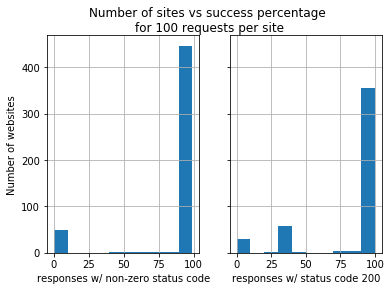

In [1059]:
f, axarr = plt.subplots(1,2, sharey=True)

axarr[0].hist(df_pivot['success_percent'])
axarr[0].set_xlabel("responses w/ non-zero status code")
axarr[0].set_ylabel("Number of websites")
axarr[0].grid(True)

axarr[1].hist(df_pivot2['pass_percent'])
axarr[1].set_xlabel("responses w/ status code 200")
#axarr[1].set_title("Number of sites for percentage of non-zero responses per site")
axarr[1].grid(True)

f.suptitle("Number of sites vs success percentage \nfor 100 requests per site")
f.savefig("results/curl_requests_response_rate_hist")

In [1086]:
d = df_pivot2[(df_pivot2['pass_percent']<35)].join(df_all.set_index('rank'))
google = d[ d['ASN']==15169 ].index

In [1087]:
df_timing[ df_timing['rank'].isin(google)].groupby(['response_code'])['rank'].count()

response_code
0        68
200    1917
302       1
403      99
404      99
503    3716
Name: rank, dtype: int64

In [1088]:
f, ax = plt.subplots()
ax.plot( df_timing[ df_timing['rank']==1]['response_code'], 'o', label='google.com')
ax.plot( df_timing[ df_timing['rank']==2]['response_code'], 'x', label='youtube.com')
# convert index to seconds - every 500 requests wait for 20 s
labels=[int(l/500) for l in ax.get_xticks().tolist()]
ax.set_xticklabels(labels)
ax.set_title("Response code for google.com and youtube.com")
ax.set_xlabel("Request counter (approx. 20s between each request)")
ax.set_ylabel("Response code [0, 200, 503]")
ax.legend(loc='best')
f.savefig("results/curl_requests_google_response")

Total responses with status code 0 (Failed) =  5638
Total responses with status code 200 (OK) =  37470
Total responses with other status codes (Unreachable, Redirected, Forbidden, etc.) =  6892
Overall success rate = 0.7494


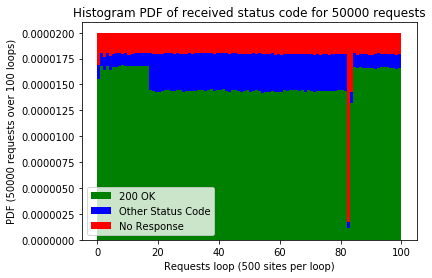

In [1089]:
data0 = [int(d) for d in df_timing[(df_timing['response_code']==0)]['response_code'].index ]
#x0,y0 = getCDF(data0)
data200 = [int(d) for d in df_timing[(df_timing['response_code']==200)]['response_code'].index ]
#x200,y200 = getCDF(data200)
dataother = [int(d) for d in df_timing[~(df_timing['response_code'].isin([0,200]))]['response_code'].index ]
#xother,yother = getCDF(dataother)

print("Total responses with status code 0 (Failed) = ", len(data0))
print("Total responses with status code 200 (OK) = ", len(data200))
print("Total responses with other status codes (Unreachable, Redirected, Forbidden, etc.) = ", len(dataother))
print("Overall success rate = %s" %(len(data200)/len(df_timing)))

f,ax = subplots()
ax.hist([data200,dataother,data0], 100, color=["green", "blue","red"], density = True, stacked=True)
ax.legend({'200 OK': "green", 'Other Status Code': "blue", 'No Response': "red"})
labels=[int(l/500) for l in ax.get_xticks().tolist()]
ax.set_xticklabels(labels)
ax.set_title("Histogram PDF of received status code for 50000 requests")
ax.set_xlabel("Requests loop (500 sites per loop)")
ax.set_ylabel("PDF (50000 requests over 100 loops)")
f.savefig("results/curl_requests_all_status_code_pdf_hist")

#### Filter the 49 unreachable sites

In [1093]:
# sites with at least one non-zero response
df_responses = df_timing[ (df_timing['status_fail']==False) ]

df_valid = df_timing[ df_timing['rank'].isin(df_responses['rank'].unique()) ]

In [1094]:
data0 = [int(d) for d in df_valid[(df_valid['response_code']==0)]['response_code'].index ]
#x0,y0 = getCDF(data0)
data200 = [int(d) for d in df_valid[(df_valid['response_code']==200)]['response_code'].index ]
#x200,y200 = getCDF(data200)
dataother = [int(d) for d in df_valid[~(df_valid['response_code'].isin([0,200]))]['response_code'].index ]
#xother,yother = getCDF(dataother)

print("Total responses with status code 0 (Failed) = ", len(data0))
print("Total responses with status code 200 (OK) = ", len(data200))
print("Total responses with other status codes (Unreachable, Redirected, Forbidden, etc.) = ", len(dataother))
print("Overall success rate = %s" %(len(data200)/len(df_valid)))

Total responses with status code 0 (Failed) =  738
Total responses with status code 200 (OK) =  37470
Total responses with other status codes (Unreachable, Redirected, Forbidden, etc.) =  6892
Overall success rate = 0.830820399113082


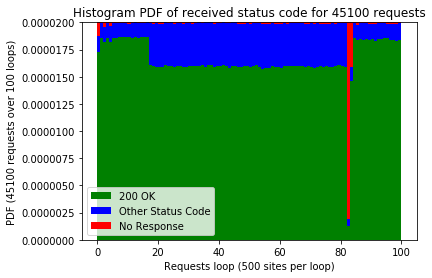

In [1095]:
f,ax = subplots()
ax.hist([data200,dataother,data0], 100, color=["green", "blue","red"], density = True, stacked=True)
ax.legend({'200 OK': "green", 'Other Status Code': "blue", 'No Response': "red"})
labels=[int(l/500) for l in ax.get_xticks().tolist()]
ax.set_xticklabels(labels)
ax.set_title("Histogram PDF of received status code for 45100 requests")
ax.set_xlabel("Requests loop (500 sites per loop)")
ax.set_ylabel("PDF (45100 requests over 100 loops)")
f.savefig("results/curl_requests_filtered_status_code_pdf_hist")

### SSL analysis
- We find out which site uses SSL by counting the difference of time between completion of the handshake and the last TCP packet. These timings are directly collected by CURL (from curl manpage):
    - time_appconnect The time, in seconds, it took from the start until the SSL/SSH/etc connect/handshake to the remote host was completed.
    - time_connect The time, in seconds, it took from the start until the TCP connect to the remote host (or proxy) was completed.
    - If time_appconnect - time_connect == 0 (or negative), we assume that SSL was not used.
- 44362 of 45100 requests received a non 0 status code in response (i.e. no failure).
- 40160 of 44362 valid responses used SSL, while 4202 did not use SSL
- Of 40160 ssl responses, 33433 had a status code 200 OK, 6727 had a status code other than 200 (but non-zero)
- Of 4202 non-ssl responses, 4037 responses had a status code 200, 165 had a status code other than 200.
- On checking we didn't find any pattern suggesting a particular period when SSL responses change.
- Based on CDF, about 45 websites have less than 20 requests that successfully use SSL. More than 90% websites successfully respond to HTTPS requests using SSL for almost all requests.
    - These 45 websites surprisingly include netflix.com, paypal.com, dailymail.co.uk, washingtonpost.com, playstation.com. This means that even though we used HTTPS, the server probably responded without SSL to load the home page.
    - To confirm we retested these 45 websites with our curl timing analysis code for just 20 requests.

In [1024]:
df_responses = df_valid[ (df_valid['status_fail']==False) ]

df_no_ssl = df_valid[ (df_valid['ssl_flag']==False) & (df_valid['status_fail']==False) ]
df_ssl = df_valid[ (df_valid['ssl_flag']==True) & (df_valid['status_fail']==False) ]

print( "Number of requests with non-zero status response:", len(df_responses) )
print( "Number of requests for which SSL was not used:", len(df_no_ssl) )
print( "Number of requests for which SSL was used:", len(df_ssl) )

df_responses.groupby(['ssl_flag', 'status_ok'])['rank'].count()

Number of requests with non-zero status response: 44362
Number of requests for which SSL was not used: 4202
Number of requests for which SSL was used: 40160


ssl_flag  status_ok
False     False          165
          True          4037
True      False         6727
          True         33433
Name: rank, dtype: int64

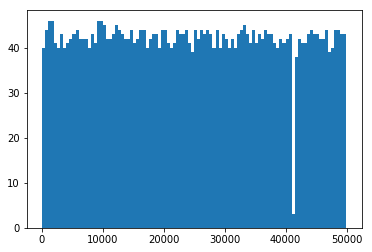

In [1025]:
i = hist( df_no_ssl.index, bins=100 )

In [1026]:
df_ssl_check = df_responses.groupby(['rank', 'ssl_flag'])['url_effective'].count().reset_index().pivot('rank','ssl_flag','url_effective').fillna(0)
df_ssl_check['ssl_success_rate'] = df_ssl_check[True]*100/(df_ssl_check[True]+df_ssl_check[False])


Text(0, 0.5, 'CDF (fraction of 451 total websites)')

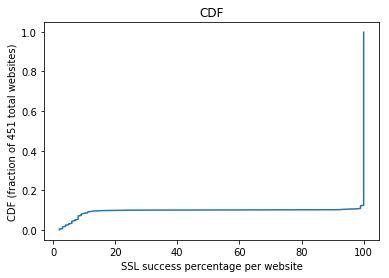

In [1027]:
xd, yd = getCDF( list(df_ssl_check['ssl_success_rate']) )
f,ax = subplots()
ax.plot(xd, yd)
ax.set_title("CDF")
ax.set_xlabel("SSL success percentage per website")
ax.set_ylabel("CDF (fraction of 451 total websites)")

In [1033]:
bad_ssl_site_indx = df_ssl_check[ df_ssl_check['ssl_success_rate'] < 20 ].index
bad_ssl_sites = df_asn_cdn[ df_asn_cdn['rank'].isin(bad_ssl_site_indx) ]

print ("Sites with bad SSL responses:\n", list( bad_ssl_sites['site'] ))

Sites with bad SSL responses:
 ['weibo.com', 'netflix.com', 'msn.com', 'paypal.com', 'thestartmagazine.com', 'zhihu.com', 'spotify.com', 'theguardian.com', 'avito.ru', 'vice.com', 'canva.com', 'patria.org.ve', 'wikihow.com', 'blogger.com', 'dailymail.co.uk', 'usps.com', 'mozilla.org', 'blackboard.com', 'ups.com', 'washingtonpost.com', 'zillow.com', 'weebly.com', 'weather.com', 'bet365.com', 'fedex.com', 'office365.com', 'doublepimp.com', 'orange.fr', 'fandom.com', 'americanexpress.com', 'oracle.com', 'cambridge.org', 'wiley.com', 'springer.com', 'samsung.com', 'namu.wiki', 'glassdoor.com', 'elsevier.com', 'skype.com', 'sberbank.ru', 'free.fr', 'bloomberg.com', 'cnbc.com', 'playstation.com', 'rarbg.to']


## 2b. Timings analysis for good responses (status code 200)
- We will only analyze those responses with status code 200, since other status codes might indicate that we never reached the site web page
- Since 4 websites had a success rate lower than 30%, we will remove them from the current analysis. These sites are ['reddit.com', 'amazon.de', 'amazon.co.uk', 'leboncoin.fr']

In [636]:
df_temp = df_timing[ ~df_timing['rank'].isin(bad_sites['site'].keys()) ]
df_filtered = df_temp[df_temp['response_code']==200]
df_redirected = df_temp[~df_temp['response_code'].isin([0,200])]

### Average timings per website
- average the calculated timings across all responses with a 200 status code

In [598]:
df_filtered.columns

Index(['response_code', 'size_download', 'size_header', 'size_request',
       'size_upload', 'url_effective', 'time_namelookup', 'time_connect',
       'time_appconnect', 'time_pretransfer', 'time_redirect',
       'time_starttransfer', 'time_total', 'rank', 't_dns', 'ssl_flag',
       't_ssl', 't_fbyte', 't_wait', 't_rx', 'size_up', 'size_dw', 'pass'],
      dtype='object')

In [599]:
df_filtered.groupby(['rank','ssl_flag'])[['size_up', 'size_dw', 't_dns',
       't_ssl', 't_fbyte', 't_wait', 't_rx']].mean()

size_up        size_dw     t_dns         t_ssl   t_fbyte  \
rank ssl_flag                                                                
1    True       76.000000   14567.060606  0.239854  9.872273e-02  0.456848   
2    True       77.000000  428223.757576  0.008310  1.021042e-01  0.224925   
3    True       78.000000  674018.818182  0.011994  2.040795e-01  0.775510   
4    True       77.000000    2843.000000  0.054017  1.819955e-01  0.473341   
5    True       79.000000   83995.989899  0.053500  1.848144e-01  0.426418   
6    True       72.000000  236159.845361  1.671953  1.902289e-01  2.036760   
7    True      154.000000  450646.428571 -0.441348  1.884625e-01  0.398409   
8    True       76.000000   90742.069767  0.033693  6.861486e-02  0.600390   
9    True      156.000000  244952.680851 -1.935363  9.649641e-01  1.165772   
11   True       75.000000  230157.072917  1.045003  1.039176e+00  2.199329   
12   True       78.000000   14564.848485  0.008108  9.922291e-02  0.235734   
13   True      150.000000  228592.132653 -0.579795  2.192272e-01  0.712703   
14   True      156.000000    5299.377551 -0.012243  1.947950e-02  0.108607   
15   True       74.000000  210615.212121  0.332346  2.578741e-01  0.996971   
16   True       74.000000  117901.183673  1.559512  1.776260e-01  2.089414   
17   True       77.000000   95939.408163  0.019197  3.944889e-01  0.950377   
18   True       78.000000   14753.181818  0.013930  1.002437e-01  0.229821   
19   True       79.000000   30846.173469  0.038024  2.034761e-01  0.682758   
20   True      239.000000   97458.878788 -1.689582  2.020202e-08  0.638951   
21   True       77.000000  570160.530612  1.355923  2.582129e-01  1.855420   
22   True       74.000000   76151.474747  0.070106  7.606260e-01  1.937241   
24   True      519.081633   98990.061224 -2.389053  1.769673e-03  0.085677   
25   True       79.000000   14766.117647  0.150595  9.740997e-02  0.373417   
26   True       78.000000   49433.555556  0.145860  2.623605e-02  0.431025   
27   True      161.000000   83421.909091 -0.849512  6.060606e-08  0.502221   
28   True       79.000000   14835.575758  0.022320  9.585058e-02  0.236755   
29   True       77.000000   18991.000000  0.216252  3.245979e-01  0.911497   
30   True       76.000000   87972.444444  0.092418  1.013957e-01  0.324888   
32   True       78.000000   14597.939394  0.017507  1.122879e-01  0.244678   
33   True       74.000000  144833.452632  0.105426  7.835826e-01  2.109465   
...                   ...            ...       ...           ...       ...   
467  True      367.000000  388935.141414 -1.017688  7.070707e-08  0.383635   
468  True       75.000000  558878.949495  0.026403  3.257470e-01  0.698965   
469  True       76.000000  273099.545455  0.229191  5.109147e-01  1.243955   
470  True      144.000000   87353.414141 -1.231539  1.949011e-01  0.941365   
471  True       84.000000   64555.252525  0.058163  5.577438e-01  1.263630   
472  True      168.000000  376745.928571 -0.214956  3.061224e-08  0.092164   
473  True      216.000000  114527.585859 -1.062912  3.552063e-01  0.698576   
474  True       79.000000   14810.970588  0.025038  9.928179e-02  0.246506   
476  True       78.000000  273010.252525  0.053442  7.685388e-02  0.219392   
477  True       78.000000  297921.171717  0.050802  7.303105e-02  0.222316   
478  True       77.000000   65895.454545  0.034466  3.471970e-01  0.984673   
479  True      163.000000   19158.303030 -0.988190  7.070707e-08  0.473640   
480  True       78.000000  196548.707071  0.033100  1.896999e-01  0.475388   
481  True       73.000000   95912.939394  0.040642  2.024535e-01  1.010715   
482  True      126.909091   23222.898990 -0.500938  4.977066e-01  0.602237   
483  True       78.000000   45977.000000  0.010160  5.877944e-01  1.171544   
485  True      154.000000  146821.282828 -1.193684  5.912306e-01  1.169428   
486  True      150.000000  151583.000000 -0.598891  3.455942e-01  0.716406   
487  True       76.000000  145035.387755